In [8]:
import sys
sys.path.append('../src')

from mcmc_norm_learning.environment import position, plot_env
from mcmc_norm_learning.algorithm_1_v4 import to_tuple
from mcmc_norm_learning.rules_4 import get_log_prob
from mcmc_norm_learning.mcmc_performance import performance
from mcmc_norm_learning.robot_task_new import task
from mcmc_norm_learning.algorithm_1_v4 import algorithm_1, over_dispersed_starting_points
from pickle_wrapper import unpickle
from collections import Counter
import pandas as pd
import yaml
import tqdm
from numpy import log
from algorithm_2_utilities import Likelihood
from IPython.utils import io

In [9]:
with open("../params_nc.yaml", 'r') as fd:
    params = yaml.safe_load(fd)

In [10]:
num_obs=params["num_observations"]
true_norm=params['true_norm']['exp']
env = unpickle(f'../data/env.pickle')

In [11]:
colour_specific = params['colour_specific']
shape_specific = params['shape_specific']
target_area_parts = params['target_area'].replace(' ', '').split(';')
target_area_part0 = position(*map(float, target_area_parts[0].split(',')))
target_area_part1 = position(*map(float, target_area_parts[1].split(',')))
target_area = (target_area_part0, target_area_part1)
print(target_area_part0.coordinates())
print(target_area_part1.coordinates())
the_task = task(colour_specific, shape_specific, target_area)

(-0.8, 0.7)
(0.25, 0.99)


In [12]:
base_path="../data_nc/exp_nc5/"
exp_paths=!ls $base_path
n_top = 5
n=params["num_observations"]

In [13]:
def iter_stats(exp_path):
    result={}
    w_nc,trial=tuple(map(lambda x: float(x.split("=")[-1]),exp_path.split(",")))
    data=unpickle(base_path+exp_path+"/obs.pickle")
    posterior_sample = unpickle(base_path+exp_path+'/posterior_nc.pickle')
    learned_expressions=Counter(map(to_tuple, posterior_sample))
    with io.capture_output() as exp_log:
        pr_result=performance(the_task,env,true_norm,learned_expressions,
                        folder_name="temp",file_name="top_norm",
                        top_n=n_top,beta=1,repeat=100000,verbose=False)
    pr_result["w_nc"]=w_nc
    pr_result["trial"]=trial
    result["w_nc"]=pr_result
    chain_details = pd.read_csv(f"{base_path+exp_path}/chain_posteriors_nc.csv")
    top_norms=chain_details.loc[chain_details.chain_pos>2*n\
                           ].groupby(["expression"]).agg({"log_posterior":["mean","count"]})
    top_norms["chain_rank"]=top_norms[[('log_posterior', 'count')]].rank(method='dense',ascending=False)
    top_norms.sort_values(by=["chain_rank"],inplace=True)
    top_norms["w_nc"]=w_nc
    top_norms["trial"]=trial
    result["trial"]=top_norms
    return(result)

In [14]:
from joblib import Parallel, delayed
stats_iters = Parallel(verbose=10, n_jobs=7, prefer="processes"\
                                     )(delayed(iter_stats)(exp_path)\
                                       for exp_path in tqdm.tqdm(exp_paths,\
                                                            desc="Loop for Individual w_nc,trial"))


Loop for Individual w_nc,trial:   0%|          | 0/36 [00:00<?, ?it/s][Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.

Loop for Individual w_nc,trial:  39%|███▉      | 14/36 [24:00<37:43, 102.88s/it][Parallel(n_jobs=7)]: Done   4 tasks      | elapsed: 25.2min

Loop for Individual w_nc,trial:  58%|█████▊    | 21/36 [48:16<33:36, 134.41s/it][Parallel(n_jobs=7)]: Done  11 tasks      | elapsed: 50.1min

Loop for Individual w_nc,trial:  78%|███████▊  | 28/36 [1:14:47<21:38, 162.30s/it][Parallel(n_jobs=7)]: Done  18 tasks      | elapsed: 76.1min

Loop for Individual w_nc,trial: 100%|██████████| 36/36 [1:44:21<00:00, 173.94s/it]
[Parallel(n_jobs=7)]: Done  27 out of  36 | elapsed: 113.0min remaining: 37.7min
[Parallel(n_jobs=7)]: Done  31 out of  36 | elapsed: 136.3min remaining: 22.0min
[Parallel(n_jobs=7)]: Done  36 out of  36 | elapsed: 144.3min finished


In [15]:
z_pr=pd.DataFrame()
for indiviaudal_results in stats_iters:
    pr_recall=indiviaudal_results["w_nc"]
    z_pr=z_pr.append(pr_recall)

In [40]:
test=z_pr.head(6)
test

,norm_rank,weight,precision,recall,F_1,w_nc,trial
0,1,0.295234,0.975291,0.977337,0.976313,0.0,1.0
1,2,0.286202,0.975145,0.975099,0.975122,0.0,1.0
2,3,0.163783,0.807429,0.968990,0.880863,0.0,1.0
3,4,0.130844,0.807201,0.970110,0.881189,0.0,1.0
4,5,0.123937,0.807105,0.970483,0.881286,0.0,1.0
5,net,1.000000,0.904918,0.973534,0.936115,0.0,1.0


In [43]:
#Net row is weighted sum of precision and recall of top 5 norms
(test.weight.iloc[:5]*test.precision.iloc[:5]).sum()

0.9049180964351324

In [47]:
chk=z_pr.groupby(["w_nc","norm_rank"]).mean()

norm_rank
1      AxesSubplot(0.125,0.125;0.775x0.755)
2      AxesSubplot(0.125,0.125;0.775x0.755)
3      AxesSubplot(0.125,0.125;0.775x0.755)
4      AxesSubplot(0.125,0.125;0.775x0.755)
5      AxesSubplot(0.125,0.125;0.775x0.755)
net    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

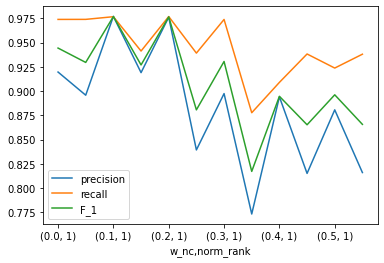

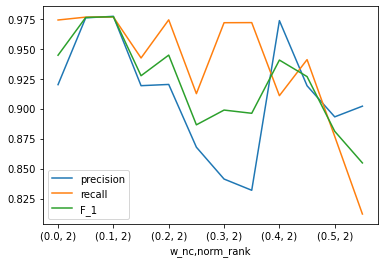

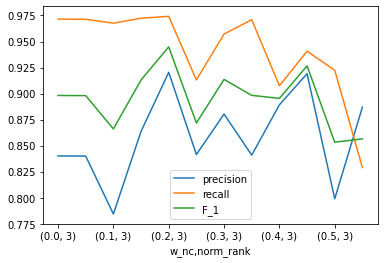

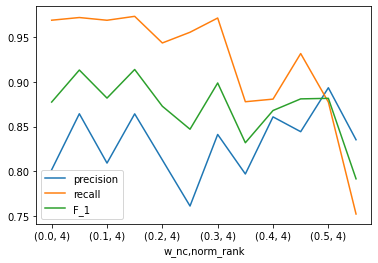

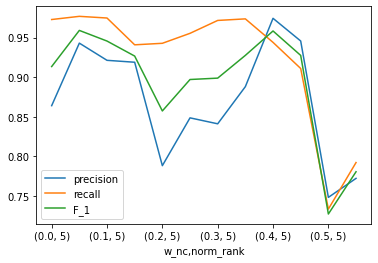

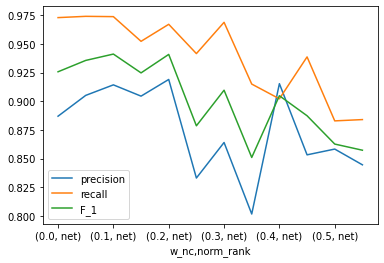

In [54]:
chk.groupby("norm_rank")[["precision","recall","F_1"]].plot()

In [144]:
z_pr.loc[(z_pr.w_nc.isin([0.0,0.25])) & (z_pr.norm_rank=="net")]

,norm_rank,weight,precision,recall,F_1,w_nc,trial
5,net,1.0,0.904918,0.973534,0.936115,0.00,1.0
5,net,1.0,0.839215,0.970042,0.898604,0.00,2.0
5,net,1.0,0.916889,0.975347,0.942502,0.00,3.0
5,net,1.0,0.807486,0.969147,0.880961,0.25,1.0
5,net,1.0,0.953361,0.888701,0.917697,0.25,2.0
5,net,1.0,0.738417,0.966935,0.837214,0.25,3.0


In [20]:
res1=z_pr.groupby(["w_nc","norm_rank"]
            ).agg({"weight":["mean"],"precision":"mean","recall":"mean","trial":("count")})
res1.to_csv("precision_recall_result_exp5_w_nc.csv")
res1

weight precision    recall trial
                    mean      mean      mean count
w_nc norm_rank                                    
0.00 1          0.313248  0.919749  0.974018     3
     2          0.291137  0.920109  0.974079     3
     3          0.187185  0.840182  0.971522     3
     4          0.106495  0.801644  0.968865     3
     5          0.101935  0.864047  0.972914     3
...                  ...       ...       ...   ...
0.55 2          0.246252  0.902136  0.812116     3
     3          0.116527  0.887032  0.829054     3
     4          0.079625  0.835189  0.752151     3
     5          0.071721  0.772161  0.792152     3
     net        1.000000  0.844600  0.884045     3

[72 rows x 4 columns]

In [21]:
z_top=pd.DataFrame()
for indiviaudal_results in stats_iters:
    pr_recall=indiviaudal_results["trial"]
    z_top=z_top.append(pr_recall)

In [22]:
z_top.columns

MultiIndex([('log_posterior',  'mean'),
            ('log_posterior', 'count'),
            (   'chain_rank',      ''),
            (         'w_nc',      ''),
            (        'trial',      '')],
           )

### Convergence Results

In [26]:
res2=z_top.groupby(["w_nc","trial"]).head(10)
res2.to_csv("top_norms_10_result_exp5_w_nc.csv")
#res2

log_posterior        \
                                                            mean count   
expression                                                               
['No-norm', 'true']                                  -549.999292  8628   
['Norms', ['Obl', ['Moved', ['Colour', 'r'], ['...   -536.213478  5812   
['Norms', ['Obl', ['Moved', ['Colour', 'any'], ...   -536.213478  5695   
['Norm', ['Obl', ['Moved', ['Colour', 'r'], ['S...   -549.070578  2371   
['Norms', ['Obl', ['Moved', ['Colour', 'r'], ['...   -537.312090  2105   
...                                                          ...   ...   
['Norms', ['Pro', ['Action', 'putdown'], ['Colo...   -556.270965   363   
['Norms', ['Pro', ['Action', 'putdown'], ['Colo...   -556.270965   289   
['Norms', ['Pro', ['Action', 'putdown'], ['Colo...   -556.270965   252   
['Norms', ['Obl', ['Next-Move', ['Colour', 'b']...   -557.775042   221   
['Norms', ['Pro', ['Action', 'putdown'], ['Colo...   -556.270965   197   

                                                   chain_rank  w_nc trial  
                                                                           
expression                                                                 
['No-norm', 'true']                                       1.0  0.00   1.0  
['Norms', ['Obl', ['Moved', ['Colour', 'r'], ['...        2.0  0.00   1.0  
['Norms', ['Obl', ['Moved', ['Colour', 'any'], ...        3.0  0.00   1.0  
['Norm', ['Obl', ['Moved', ['Colour', 'r'], ['S...        4.0  0.00   1.0  
['Norms', ['Obl', ['Moved', ['Colour', 'r'], ['...        5.0  0.00   1.0  
...                                                       ...   ...   ...  
['Norms', ['Pro', ['Action', 'putdown'], ['Colo...        6.0  0.55   3.0  
['Norms', ['Pro', ['Action', 'putdown'], ['Colo...        7.0  0.55   3.0  
['Norms', ['Pro', ['Action', 'putdown'], ['Colo...        8.0  0.55   3.0  
['Norms', ['Obl', ['Next-Move', ['Colour', 'b']...        9.0  0.55   3.0  
['Norms', ['Pro', ['Action', 'putdown'], ['Colo...       10.0  0.55   3.0  

[360 rows x 5 columns]

In [146]:
z_top.groupby(["w_nc","trial"]).head(5).to_csv("top_norms_every_exp.csv")

In [139]:
z_top.loc[z_top.w_nc==0.25].groupby(["w_nc","trial"]).head(2)

log_posterior         \
                                                            mean  count   
expression                                                                
['Norm', ['Obl', ['Moved', ['Colour', 'any'], [...   -544.503475   9877   
['No-norm', 'true']                                  -549.999292   9498   
['Norm', ['Obl', ['Moved', ['Colour', 'any'], [...   -542.380497  10432   
['Norm', ['Obl', ['Moved', ['Colour', 'r'], ['S...   -542.380497   9554   
['No-norm', 'true']                                  -549.999292  28209   
['Norm', ['Obl', ['Moved', ['Colour', 'any'], [...   -556.304083    458   

                                                   chain_rank  w_nc trial  
                                                                           
expression                                                                 
['Norm', ['Obl', ['Moved', ['Colour', 'any'], [...        1.0  0.25   1.0  
['No-norm', 'true']                                       2.0  0.25   1.0  
['Norm', ['Obl', ['Moved', ['Colour', 'any'], [...        1.0  0.25   2.0  
['Norm', ['Obl', ['Moved', ['Colour', 'r'], ['S...        2.0  0.25   2.0  
['No-norm', 'true']                                       1.0  0.25   3.0  
['Norm', ['Obl', ['Moved', ['Colour', 'any'], [...        2.0  0.25   3.0

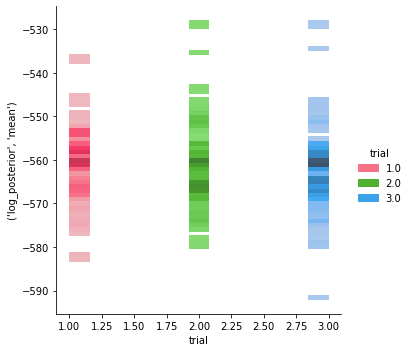

In [85]:
import seaborn as sns
fig, axs = plt.subplots(5,5,figsize=(7,10),dpi=200):
    z_top.loc[z_top.w_nc==0.0]
    sns.displot(grp.reindex(),x="trial", y=('log_posterior',  'mean'), hue="trial",\
            kind="hist",palette=sns.color_palette("husl", 3),dpi=300)

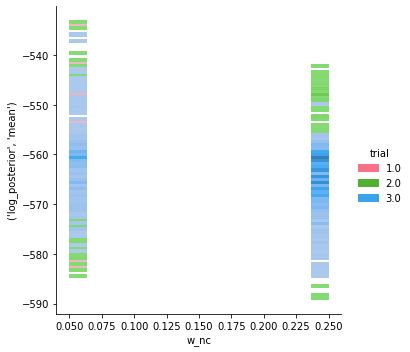

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(z_top.loc[z_top.w_nc.isin([0.25,0.05])].reindex(),x="w_nc", y=('log_posterior',  'mean'), hue="trial",\
            kind="hist",palette=sns.color_palette("husl", 3))

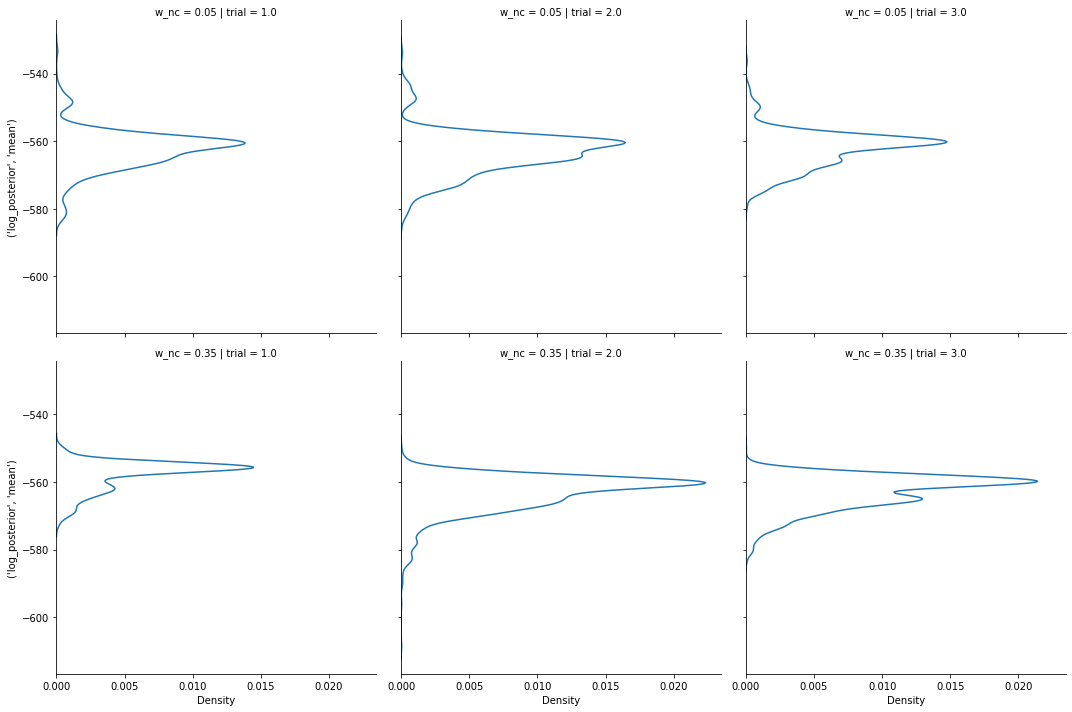

In [125]:
sns_plot=sns.displot(data=z_top.loc[z_top.w_nc.isin([0.05,0.35])],\
                     y=('log_posterior',  'mean'),row="w_nc",col="trial", kind="kde")
sns_plot.savefig("conv_arg.jpg",dpi=300)

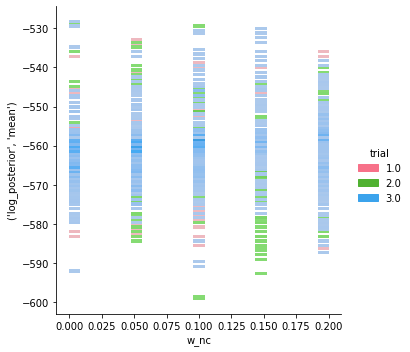

In [83]:
import seaborn as sns
ax=sns.displot(z_top.loc[z_top.w_nc<0.25].reindex(),x="trial", y=('log_posterior',  'mean'), hue="trial",\
            kind="hist",palette=sns.color_palette("husl", 3))

In [60]:
z_top.reindex().columns

MultiIndex([('log_posterior',  'mean'),
            ('log_posterior', 'count'),
            (   'chain_rank',      ''),
            (         'w_nc',      ''),
            (        'trial',      '')],
           )

In [ ]:
loc[z_top.w_nc==0.0]

### Collate convergence

In [27]:
!touch "exp5_convergence.txt"

In [28]:
for exp_path in exp_paths:
    #w_nc,trial=tuple(map(lambda x: float(x.split("=")[-1]),exp_path.split(",")))
    !echo {exp_path} >> exp5_convergence.txt
    !cat {base_path+exp_path+"/conv_test_nc.txt"} >> exp5_convergence.txt
    !echo -e "\n ---" >> exp5_convergence.txt

### Cp cnc_movement images

In [35]:
for exp_path in exp_paths:
    !cp {base_path+exp_path+"/cnc_movement.jpg"} ../../ICJAI21/exp5/{exp_path+",cnc_movmt.jpg"}